In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import re
import string
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
nltk.download("vader_lexicon")
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Angga\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Angga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

LABELLING USING LEXICON BASED APPROACH

In [2]:

# Baca data dari file Excel dan gabungkan
dataAnis = pd.read_excel('dataset/anies.xlsx')
dataPrabowo = pd.read_excel('dataset/prabowo.xlsx')
dataGanjar = pd.read_excel('dataset/ganjar.xlsx')
data = pd.concat([dataAnis, dataPrabowo, dataGanjar])

data = data[['full_text']]

sentiments = SentimentIntensityAnalyzer()
data["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in data["full_text"]]
data["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in data["full_text"]]
data["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in data["full_text"]]
data["Compound"] = [sentiments.polarity_scores(i)["compound"] for i in data["full_text"]]

score= data["Compound"].values
sentiment = []
for i in score:
  if i >= 0.05:
    sentiment.append('positif')
  elif i <= -0.05 :
    sentiment.append('negatif')
  else:
    sentiment.append('netral')
data["sentiment"] = sentiment

data = data[['full_text', 'sentiment']]

data['sentiment'].value_counts()

sentiment
netral     1626
positif      86
negatif      42
Name: count, dtype: int64

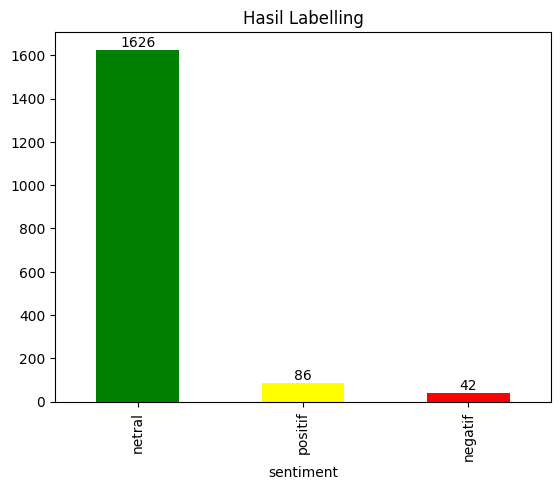

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

count_Class = pd.value_counts(data["sentiment"], sort=True)
ax = count_Class.plot(kind='bar', color=["green", "yellow", "red"])
plt.title('Hasil Labelling')

# Menambahkan teks jumlah di atas masing-masing batang
for i, v in enumerate(count_Class):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.show()


In [4]:
data['casefolding'] = data['full_text'].str.lower()

def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus @..
    text = re.sub(r'#', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]+', '', text) # menghapus RT
    text = re.sub(r'https?:\/\/\S+', '', text) # menghapus url
    text = re.sub(r':\)', '', text) # menghapus icon
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text) # menghapus single character
    text = re.sub(r'\s+', ' ', text) # menghapus spasi ganda
    text = re.sub(r'[^\w\s]', '', text) # menghapus punctuation
    text = re.sub(r'\.+', '', text) #menghilangkan teks yang mengandung akhiran MULTIPLE TITIK (...)
    text = re.sub(r'\d+', '', text) #menghilangkan teks yang mengandung angka
    text = re.sub(r'\b\w{1,2}\b', '', text) #menghilangkan teks yang mengandung 1-2 huru
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.encode('ascii', 'ignore').decode('ascii') # menghapus non-ascii (EMOTICON)
    return text

data['cleansing'] = data['casefolding'].apply(clean_text)
# delete row with null value
data = data.dropna()
# menghapus row yang memiliki nilai text kosong
data = data[data['cleansing'] != '']
data.reset_index(drop=True, inplace = True)
# Menghapus text duplikat
data.cleansing.duplicated().sum()
data.loc[data.cleansing.duplicated(), :]
data.drop_duplicates(subset=['cleansing'], inplace=True)
data.reset_index(drop=True, inplace = True)
                
#TOKENIZING
def tokenizing(text):
    nstr = text.split(' ')
    md= []
    a = -1
    for hu in nstr:
        a = a + 1
    if hu == '':
        md.append(a)
    p = 0
    b = 0
    for q in md:
        b = q - p
        del nstr[b]
        p = p + 1
    return nstr
    
data['tokenizing'] = data['cleansing'].apply(tokenizing)

def stopword_removal(text):
    factory = stopwords.words('indonesian', 'english')
    x = []
    dkk = []
    def myFunc(x):
        if x in factory:
            return False
        else:
            return True
    fit = filter(myFunc, text)
    for x in fit:
        dkk.append(x)
    return dkk               
data['stopword_removal'] = data['tokenizing'].apply(stopword_removal)
data.to_excel('data/all_preprocessing.xlsx')
data.head()

,full_text,sentiment,casefolding,cleansing,tokenizing,stopword_removal
0,"""""Dapat info @ganjarpranowo bakal gandeng sama...",netral,"""""dapat info @ganjarpranowo bakal gandeng sama...",dapat info bakal gandeng sama prof buat rebut ...,"[dapat, info, bakal, gandeng, sama, prof, buat...","[info, gandeng, prof, rebut, suara, amp, , jat..."
1,"""""Pak @aniesbaswedan bukan politisi. Pemilu it...",negatif,"""""pak @aniesbaswedan bukan politisi. pemilu it...",pak bukan politisi pemilu itu mainannya partai...,"[pak, bukan, politisi, pemilu, itu, mainannya,...","[politisi, pemilu, mainannya, partai, politik,..."
2,"""""Saya tak tahu apakah narasi-narasi janji @ca...",netral,"""""saya tak tahu apakah narasi-narasi janji @ca...",saya tak tahu apakah narasinarasi janji ini su...,"[saya, tak, tahu, apakah, narasinarasi, janji,...","[narasinarasi, janji, dikonsultasikan, bumeran..."
3,"""""Maaf cak @cakimiNOW @aniesbaswedan saya sang...",positif,"""""maaf cak @cakiminow @aniesbaswedan saya sang...",maaf cak saya sangat tidak setuju yang sudah b...,"[maaf, cak, saya, sangat, tidak, setuju, yang,...","[maaf, cak, setuju, berjalan, dananya, nggak, ..."
4,"""""Kata Anies-Cak Imin soal Ganjar Muncul di Vi...",netral,"""""kata anies-cak imin soal ganjar muncul di vi...",kata aniescak imin soal ganjar muncul video a...,"[kata, aniescak, imin, soal, ganjar, muncul, ,...","[aniescak, imin, ganjar, muncul, , video, azan..."


In [11]:
data = data[['stopword_removal', 'sentiment']]
data.rename(columns={'stopword_removal':'text'}, inplace=True)
data.to_csv('data/data.csv', index=False)


KeyError: "['stopword_removal'] not in index"

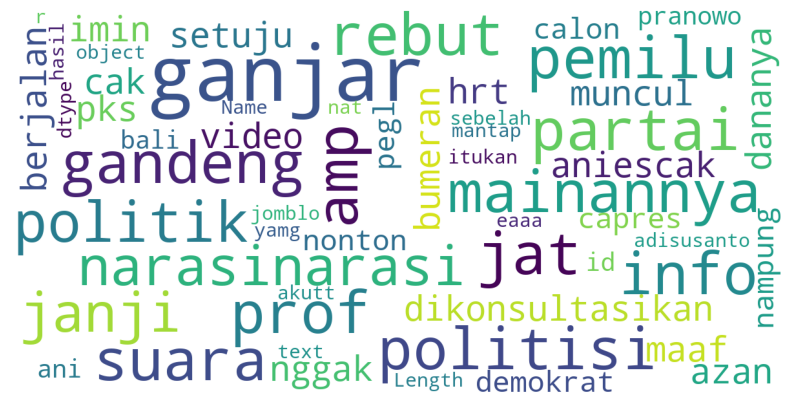

In [9]:
# show wordlcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

stopwords = stopwords.words('indonesian')

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(data['text'])

TRAINING MULTINOMIAL NAIVE BAYES CLASSIFIER

In [15]:
# Baca data dari file CSV
df = pd.read_csv('data/data.csv')
df = df[['text', 'sentiment']]

# Bagi data menjadi data latih dan data uji
X = df['text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Ekstraksi fitur menggunakan CountVectorizer
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Melatih model dengan Naive Bayes Classifier
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Melakukan prediksi
y_pred = clf.predict(X_test)

# Menampilkan hasil
print("Accuracy:", accuracy_score(y_test, y_pred))

# Menampilkan classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 0.9197530864197531
Classification Report:
              precision    recall  f1-score   support

     negatif       0.33      0.11      0.17         9
      netral       0.93      0.99      0.96       299
     positif       0.50      0.06      0.11        16

    accuracy                           0.92       324
   macro avg       0.59      0.39      0.41       324
weighted avg       0.89      0.92      0.89       324



In [16]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(cm, index=['Hasil Label Negatif', 'Hasil Label Netral', 'Hasil Label Positif'], columns=['Prediksi negatif', 'Prediksi netral', 'Prediksi positif'])




,Prediksi negatif,Prediksi netral,Prediksi positif
Hasil Label Negatif,1,8,0
Hasil Label Netral,2,296,1
Hasil Label Positif,0,15,1
